<a href="https://colab.research.google.com/github/mchong6/RetrieveInStyle/blob/main/RIS_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/mchong6/RetrieveInStyle.git
%cd RetrieveInStyle
!pip install tqdm gdown scikit-learn scipy lpips dlib opencv-python

Cloning into 'RetrieveInStyle'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 52 (delta 17), reused 39 (delta 9), pack-reused 0
Unpacking objects: 100% (52/52), done.
/content/RetrieveInStyle
     |████████████████████████████████| 61kB 6.3MB/s 


# OPTIONAL: Projecting real images
Upload your image here and run projection code. You can skip this step if you just want to use the pre-projected images used in the rest of the section. Inverted codes will be saved at ./inversion_codes/FILENAME.pt

Note not all GAN inversion will be good. Might have to try a few times to get a good one. You do not have to use this GAN inversion code here, you can always use another GAN inversion method and RIS can work with it.

In [2]:
from google.colab import files
from util import align_face
import os
from projector import projection


# upload your own image
uploaded = files.upload()
filepath = list(uploaded.keys())[0]

Saving emma_stone.jpeg to emma_stone.jpeg


Downloading...
From: https://drive.google.com/uc?id=11BDmNKS1zxSZxkgsEvQoKgFd8J264jKp
To: /content/RetrieveInStyle/dlibshape_predictor_68_face_landmarks.dat
99.7MB [00:01, 71.7MB/s]


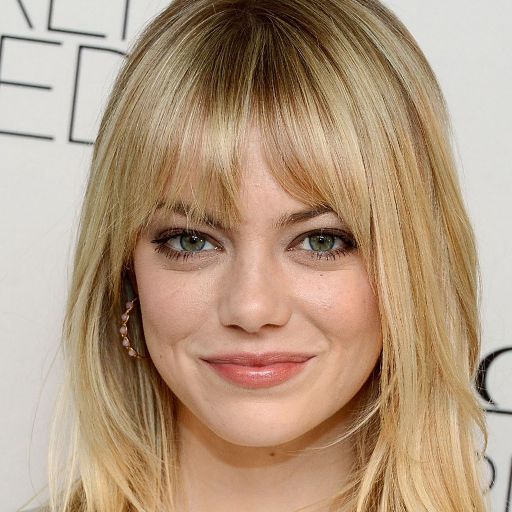

In [3]:
# aligns and crops face
cropped_face = align_face(filepath)
cropped_face

In [4]:
# run GAN inversion
filename = os.path.splitext(filepath)[0]
projection(cropped_face, filename)

Downloading...
From: https://drive.google.com/uc?id=1oE_mIKf-Vr7b3J04l2UjsSrxZiw-UuFg
To: /content/RetrieveInStyle/inversion_stats.npz
661MB [00:15, 43.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Yr7KuD959btpmcKGAUsbAk5rPjX2MytK
To: /content/RetrieveInStyle/stylegan2-ffhq-config-f.pt
133MB [00:04, 27.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KW7bjndL3QG3sxBbZxreGHigcCCpsDgn
To: /content/RetrieveInStyle/model_ir_se50.pt
175MB [00:08, 19.7MB/s]


Loading ResNet ArcFace
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0/1000 [00:00<?, ?it/s]

Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/vgg.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
perceptual: 2.0221; mse: 0.0302; gaussian: 0.3729 id: 0.0148: 100%|██████████| 1000/1000 [05:48<00:00,  2.87it/s]


In [5]:
import torch
from torch import nn
import numpy as np
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
import matplotlib.pyplot as plt
import torch.nn.functional as F
from model import *
from spherical_kmeans import MiniBatchSphericalKMeans as sKmeans
from tqdm import tqdm as tqdm
import pickle
import warnings
warnings.filterwarnings("ignore", category=UserWarning) # get rid of interpolation warning
from util import *

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
# Load pretrained generator

generator = Generator(1024, 512, 8, channel_multiplier=2).cuda().eval()

# load model file from current directory
ensure_checkpoint_exists('stylegan2-ffhq-config-f.pt')
ckpt = torch.load('stylegan2-ffhq-config-f.pt', map_location=lambda storage, loc: storage)
generator.load_state_dict(ckpt["g_ema"], strict=False)
with torch.no_grad():
    mean_latent = generator.mean_latent(50000)
    
M_device = 'cpu' # if GPU memory is low, use cpu instead

# Load pre-generated catalog or compute yourelf

In [7]:
truncation = 0.5
stop_idx = 11 # choose 32x32 layer to do kmeans clustering
n_clusters = 18 # Number of Kmeans cluster

# load pre generated catalog
clusterer = pickle.load(open("catalog.pkl", "rb"))

# compute it yourself using this code
# batch = 20
# total_num = 200
# activations = []

# for i in tqdm(range(total_num//batch)):
#     with torch.no_grad():
#         sample_z = torch.randn([batch, 512]).cuda()
#         sample = generator.get_latent(sample_z, truncation=truncation, mean_latent=mean_latent)
#         outputs = generator(sample, stop_idx=stop_idx, is_cluster=1) # [b, c, h, w]
#         activations.append(outputs[-1][0].cpu())

# activations = torch.cat(activations, 0)
# activations = flatten_act(activations)
# clusterer = sKmeans(n_clusters=n_clusters, max_iter=100, batch_size=100)
# clusterer.fit(activations)

# Visualize clusters

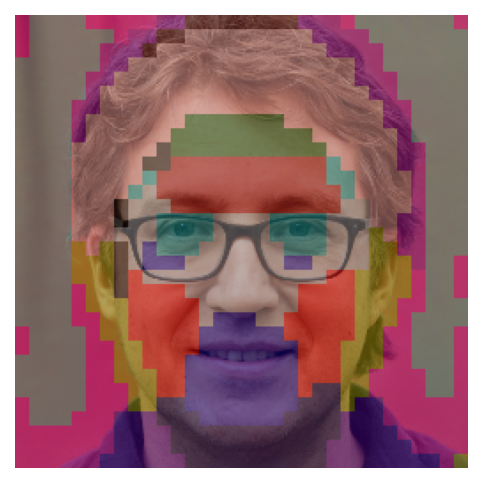

In [8]:
plt.rcParams['figure.dpi'] = 150

with torch.no_grad():
    sample_z = torch.randn([1, 512]).cuda()
    sample_w = generator.get_latent(sample_z, truncation=truncation, mean_latent=mean_latent)
    sample, outputs = generator(sample_w, is_cluster=1) # [b, c, h, w]

# obtain 32x32 activations and classify using kmeans
act = flatten_act(outputs[stop_idx][0])
b,c,h,w = outputs[stop_idx][0].size()

alpha = 0.5
seg_mask = clusterer.predict(act)
seg_mask = torch.from_numpy(seg_mask).view(1,h,w)
seg_out = decode_segmap(seg_mask)

sample_d = F.interpolate(sample, size=(256,256), mode='bilinear').cpu()
seg_out_d = F.interpolate(seg_out, size=(256,256), mode='nearest')
out = alpha*seg_out_d + (1-alpha)*sample_d

display_image(out)

# Label the clusters

Define what segmentation classes you are interested in and correspond the kmeans clusters to those classes. If you are using the precomputed catalog, you do not have to change this. Otherwise, you have to remap the kmeans clusters to the segmentation classes.

These assignments are fixed for precomputed catalog. If you choose to regenerate the catalog yourself, this has to be updated manually.



In [9]:
#Gives an index to each feature we care about
labels2idx = {
    'nose': 0,
    'eyes': 1,
    'mouth':2,
    'hair': 3,
    'background': 4,
    'cheeks': 5,
    'neck': 6,
    'clothes': 7,
}

# Assign to each feature the cluster index from segmentation
labels_map = {
    0: torch.tensor([7]),
    1: torch.tensor([1,6]),
    2: torch.tensor([4]),
    3: torch.tensor([0,3,5,8,10,15,16]),
    4: torch.tensor([11,13,14]),
    5: torch.tensor([9]),
    6: torch.tensor([17]),
    7: torch.tensor([2,12]),
}

idx2labels = dict((v,k) for k,v in labels2idx.items())
n_class = len(labels2idx)

In [10]:
# compute M given a style code.
@torch.no_grad()
def compute_M(w, device='cuda'):
    M = []
    
    # get segmentation
    _, outputs = generator(w, is_cluster=1)
    cluster_layer = outputs[stop_idx][0]
    activation = flatten_act(cluster_layer)
    seg_mask = clusterer.predict(activation)
    b,c,h,w = cluster_layer.size()

    # create masks for each feature
    all_seg_mask = []
    seg_mask = torch.from_numpy(seg_mask).view(b,1,h,w,1).to(device)
    
    for key in range(n_class):
        # combine masks for all indices for a particular segmentation class
        indices = labels_map[key].view(1,1,1,1,-1) 
        key_mask = (seg_mask == indices.to(device)).any(-1) #[b,1,h,w]
        all_seg_mask.append(key_mask)
        
    all_seg_mask = torch.stack(all_seg_mask, 1)

    # go through each activation layer and compute M
    for layer_idx in range(len(outputs)):
        layer = outputs[layer_idx][1].to(device)
        b,c,h,w = layer.size()
        layer = F.instance_norm(layer)
        layer = layer.pow(2)
        
        # resize the segmentation masks to current activations' resolution
        layer_seg_mask = F.interpolate(all_seg_mask.flatten(0,1).float(), align_corners=False, 
                                     size=(h,w), mode='bilinear').view(b,-1,1,h,w)
        
        masked_layer = layer.unsqueeze(1) * layer_seg_mask # [b,k,c,h,w]
        masked_layer = (masked_layer.sum([3,4])/ (h*w))#[b,k,c]

        M.append(masked_layer.to(device))

    M = torch.cat(M, -1) #[b, k, c]
    
    # softmax to assign each channel to a particular segmentation class
    M = F.softmax(M/.1, 1)
    # simple thresholding
    M = (M>.8).float()
    
    # zero out torgb transfers, from https://arxiv.org/abs/2011.12799
    for i in range(n_class):
        part_M = style2list(M[:, i])
        for j in range(len(part_M)):
            if j in rgb_layer_idx:
                part_M[j].zero_()
        part_M = list2style(part_M)
        M[:, i] = part_M

    return M

# Facial Feature Transfer

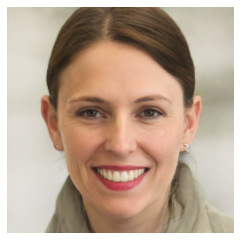

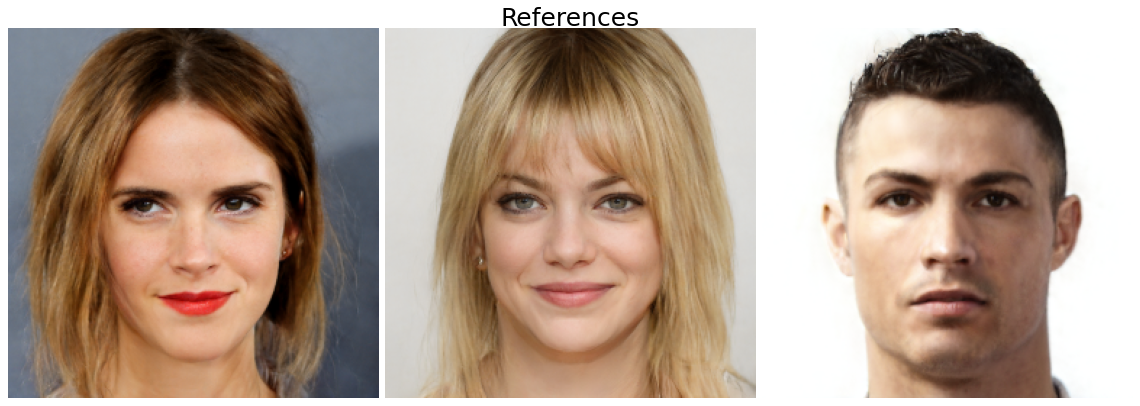

In [11]:
plt.rcParams['figure.dpi'] = 75

# load codes from inverted real images using our projection code
with torch.no_grad():
    '''
    if you gan inverted in the previous cell, you can call it here with variable filename
    otherwise, you can randomly generate or call a pre-inverted image
    '''
    source = load_source(['jacinta'], generator)
    source_im, _ = generator(source)
    display_image(source_im, size=256)
    
    ref = load_source(['emma_watson', 'emma_stone', 'ronaldo'], generator)
    ref_im, _ = generator(ref)
    ref_im = downsample(ref_im)
    
    show(normalize_im(ref_im).permute(0,2,3,1).cpu(), title='References')

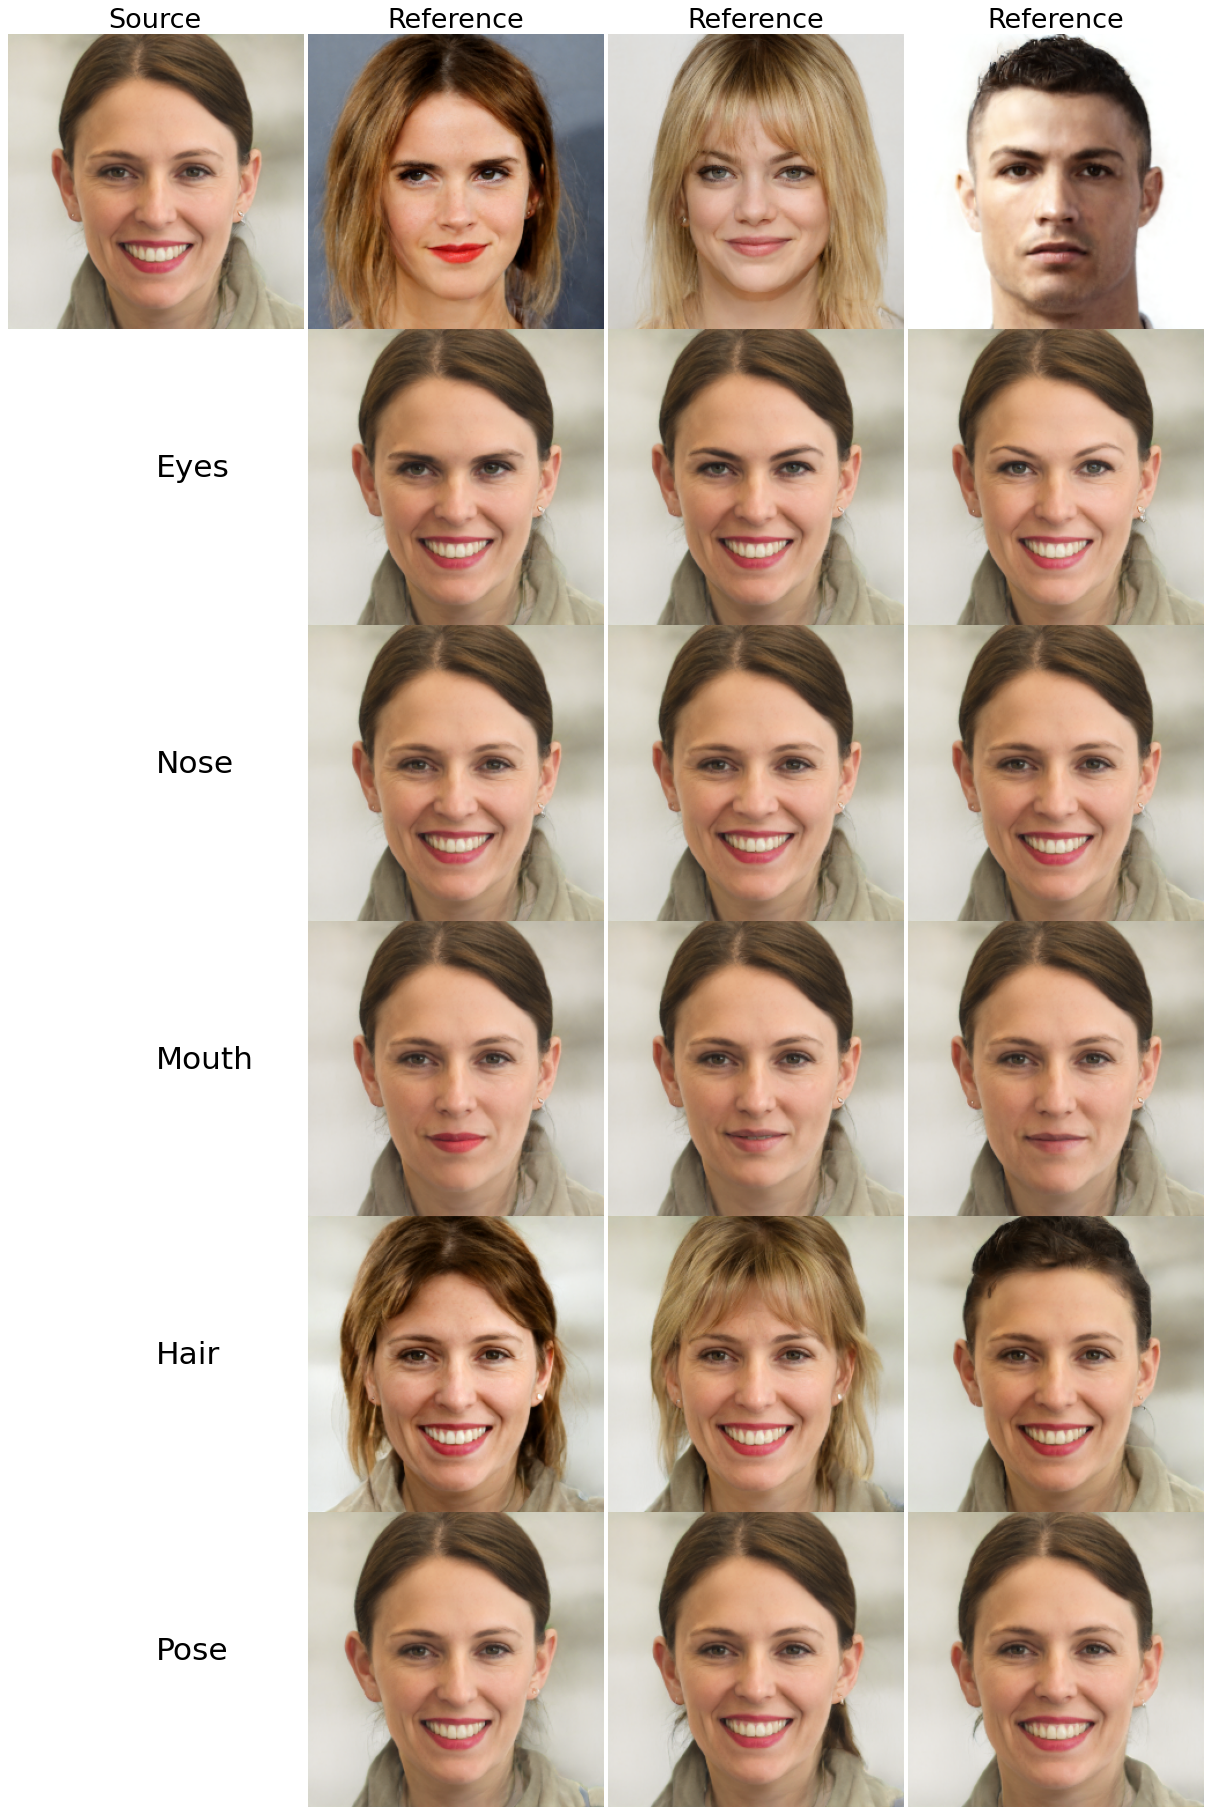

In [12]:
# Compute M for both source and reference images
source_M = compute_M(source, device=M_device)
ref_M = compute_M(ref, device=M_device)

# Find relevant channels for source and reference by taking max over their individual M
max_M = torch.max(source_M.expand_as(ref_M), ref_M)
max_M = add_pose(max_M, labels2idx)

all_im = {}

with torch.no_grad():    
    # features we are interest in transferring
    parts = ('eyes', 'nose', 'mouth', 'hair','pose')
    for label in parts:
        if label == 'pose':
            idx = -1
        else:
            idx = labels2idx[label]
            
        part_M = max_M[:,idx].cuda()
        blend = style2list(add_direction(source, ref, part_M, 1.))
            
        blend_im, _ = generator(blend)
        blend_im = downsample(blend_im).cpu()
        all_im[label] = normalize_im(blend_im)
        
part_grid(normalize_im(source_im.detach()), normalize_im(ref_im.detach()), all_im);

# Plot alpha interpolation

We can control the degree of feature transfer by controlling alpha

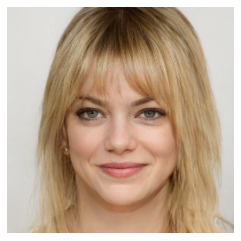

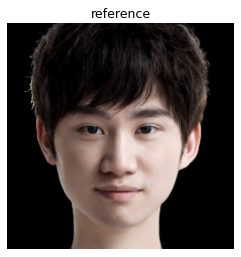

In [20]:
plt.rcParams['figure.dpi'] = 75

torch.manual_seed(3913)

'''
An example of generating with random noise
'''
# with torch.no_grad():
#     source = generator.get_latent(torch.randn([1, 512]).cuda(), truncation=truncation, mean_latent=mean_latent)
#     ref = generator.get_latent(torch.randn([1, 512]).cuda(), truncation=truncation, mean_latent=mean_latent)
#     source_im, _ = generator(source)
#     ref_im, _ = generator(ref)
    
#     source_im = downsample(source_im)
#     ref_im = downsample(ref_im)

#     display_image(source_im, title='source')
#     display_image(ref_im, title='reference')
    
    
with torch.no_grad():
    source = load_source(['emma_stone'], generator)
    source_im, _ = generator(source)
    display_image(source_im, size=256)
    
    ref = load_source(['doinb'], generator)
    ref_im, _ = generator(ref)
    ref_im = downsample(ref_im)
    display_image(ref_im, title='reference')

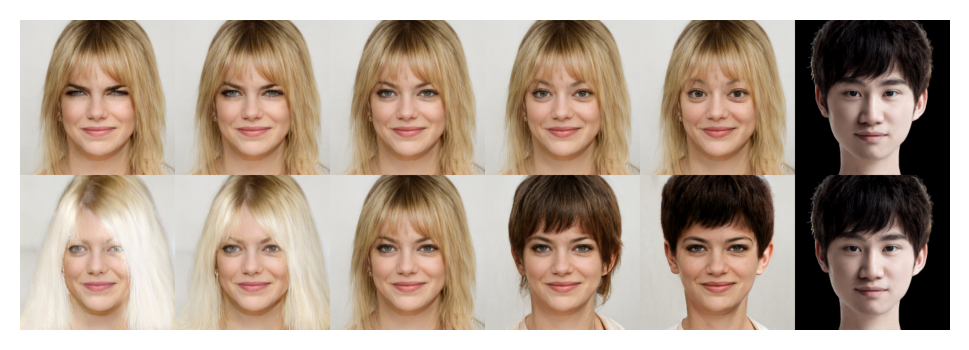

In [21]:
plt.rcParams['figure.dpi'] = 200 

source_M = compute_M(source, device=M_device)
ref_M = compute_M(ref, device=M_device)

max_M = torch.max(source_M.expand_as(ref_M), ref_M)
max_M = add_pose(max_M, labels2idx)

labels = ('eyes', 'hair') # choose what feature to interpolate {eyes/nose/mouth/hair/pose}
max_alpha = 1.5 # max range to interpolate

all_im = []
with torch.no_grad():    
    for label in labels:
        row = []
        
        if label == 'pose':
            idx = -1
        else:
            idx = labels2idx[label]

        for alpha in np.linspace(-max_alpha, max_alpha, 5):
            part_M = max_M[:,idx].cuda() 
            blend = style2list(add_direction(source, ref, part_M, alpha))
            blend_im, _ = generator(blend)
            blend_im = downsample(blend_im).cpu()
            row.append(blend_im)

        row.append(ref_im.cpu())
        row = torch.cat(row, -1)
        all_im.append(row)
        
    all_im = torch.cat(all_im, 2)
    display_image(all_im, size=None)

# Fine-grained feature retrieval
First generate a large dataset. Large scale GAN inversion possible using a trained encoder.

In [15]:
torch.manual_seed(12390)

num_data = 5000
dataset = torch.randn([num_data, 512]).cuda()
with torch.no_grad():
    dataset_w = generator.get_latent(dataset, truncation=truncation, mean_latent=mean_latent)
    dataset_M = []
    for i in tqdm(range(num_data)):
        # have to use cuda for this or it will be very slow
        dataset_M.append(compute_M(index_layers(dataset_w, i), device='cuda'))

    dataset_M = remove_2048(torch.cat(dataset_M, 0), labels2idx).cuda() #[N, K, C]

100%|██████████| 5000/5000 [17:19<00:00,  4.81it/s]


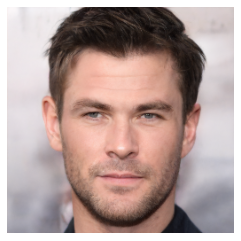

In [16]:
plt.rcParams['figure.dpi'] = 75 

torch.manual_seed(18399)

with torch.no_grad():
    query_w = load_source(['chris_hemsworth'], generator)
    
    query_im, _ = generator(query_w)
    display_image(query_im)

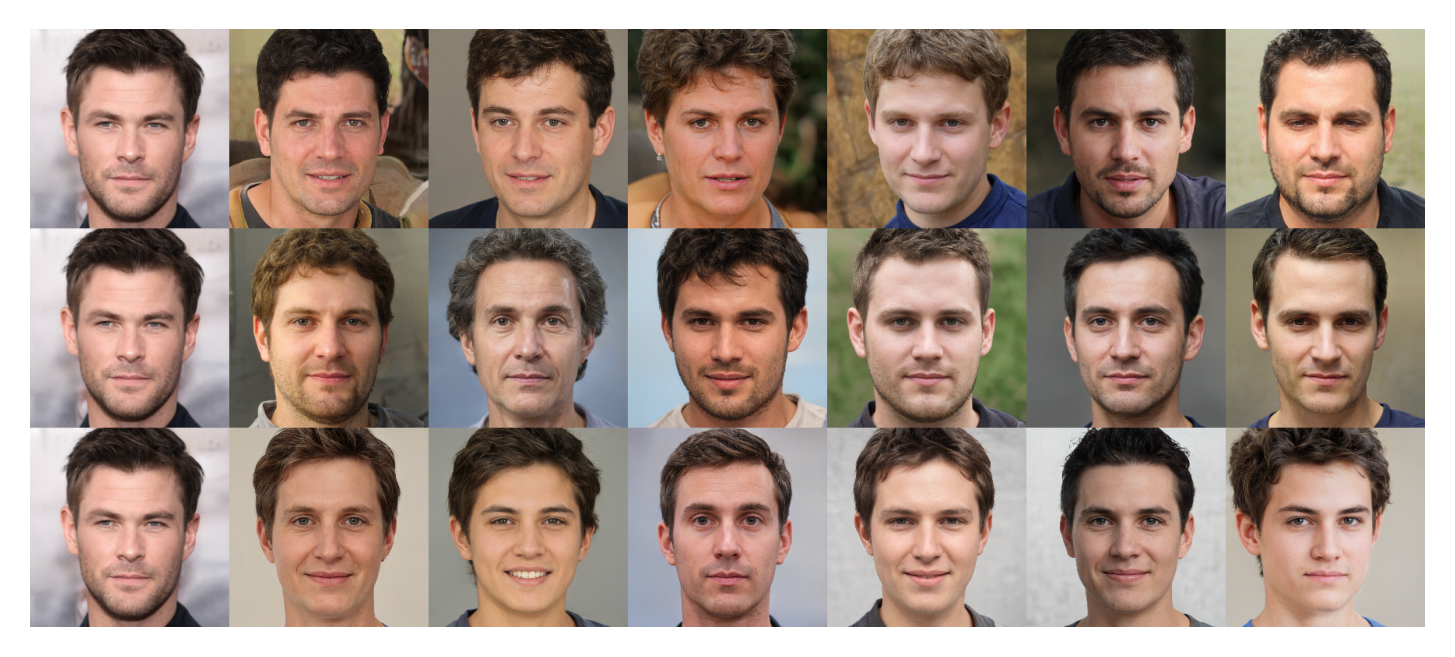

In [17]:
plt.rcParams['figure.dpi'] = 300

num_nn = 6
all_im = []
query_M = remove_2048(compute_M(query_w, device=M_device), labels2idx).cuda()

r_query_w = list2style(query_w)
r_dataset_w = list2style(dataset_w)

# normalize each style dimension
largest = r_dataset_w.abs().max(0, keepdim=True)[0] + 1e-8
norm_query_w = r_query_w/largest
norm_target_w = r_dataset_w/largest

# choose what features to perform retrieval on
# parts = ('eyes', 'nose', 'mouth', 'hair')
parts = ('eyes', 'mouth', 'hair',)

# perform cosine similarity w.r.t a given feature
with torch.no_grad():
    for part in parts:
        idx = labels2idx[part]
        
        source_part = norm_query_w * query_M[:,idx].cuda()
        target_part = norm_target_w * dataset_M[:,idx].cuda()
        
        distance = cos_dist(target_part, source_part)  
        nearest_neighbors = torch.sort(distance)[1][:num_nn]

        row = [query_im.cpu()]
        for idx in nearest_neighbors:
            nn_w = index_layers(dataset_w, int(idx))
            nn_image, _ = generator(nn_w)
            row.append(nn_image.cpu())
        row = [downsample(a) for a in row]
        row = torch.cat(row, -1)
        all_im.append(row)
        
    all_im = torch.cat(all_im,-2)
    display_image(all_im, size=None)

# OPTIONAL: Compute some stats for GAN inversion. Skip if not using real images

We perform GAN inversion by imposing a Gaussian prior as follows from https://arxiv.org/abs/2009.06529. However, we also show that the gaussian property can also be observed in the style space of the StyleGAN even without and transformations (they use leakyrelu in their paper to convert w into gaussian). We observe that imposing the gaussian prior in the style space during inversion gives better reconstruction and editability.


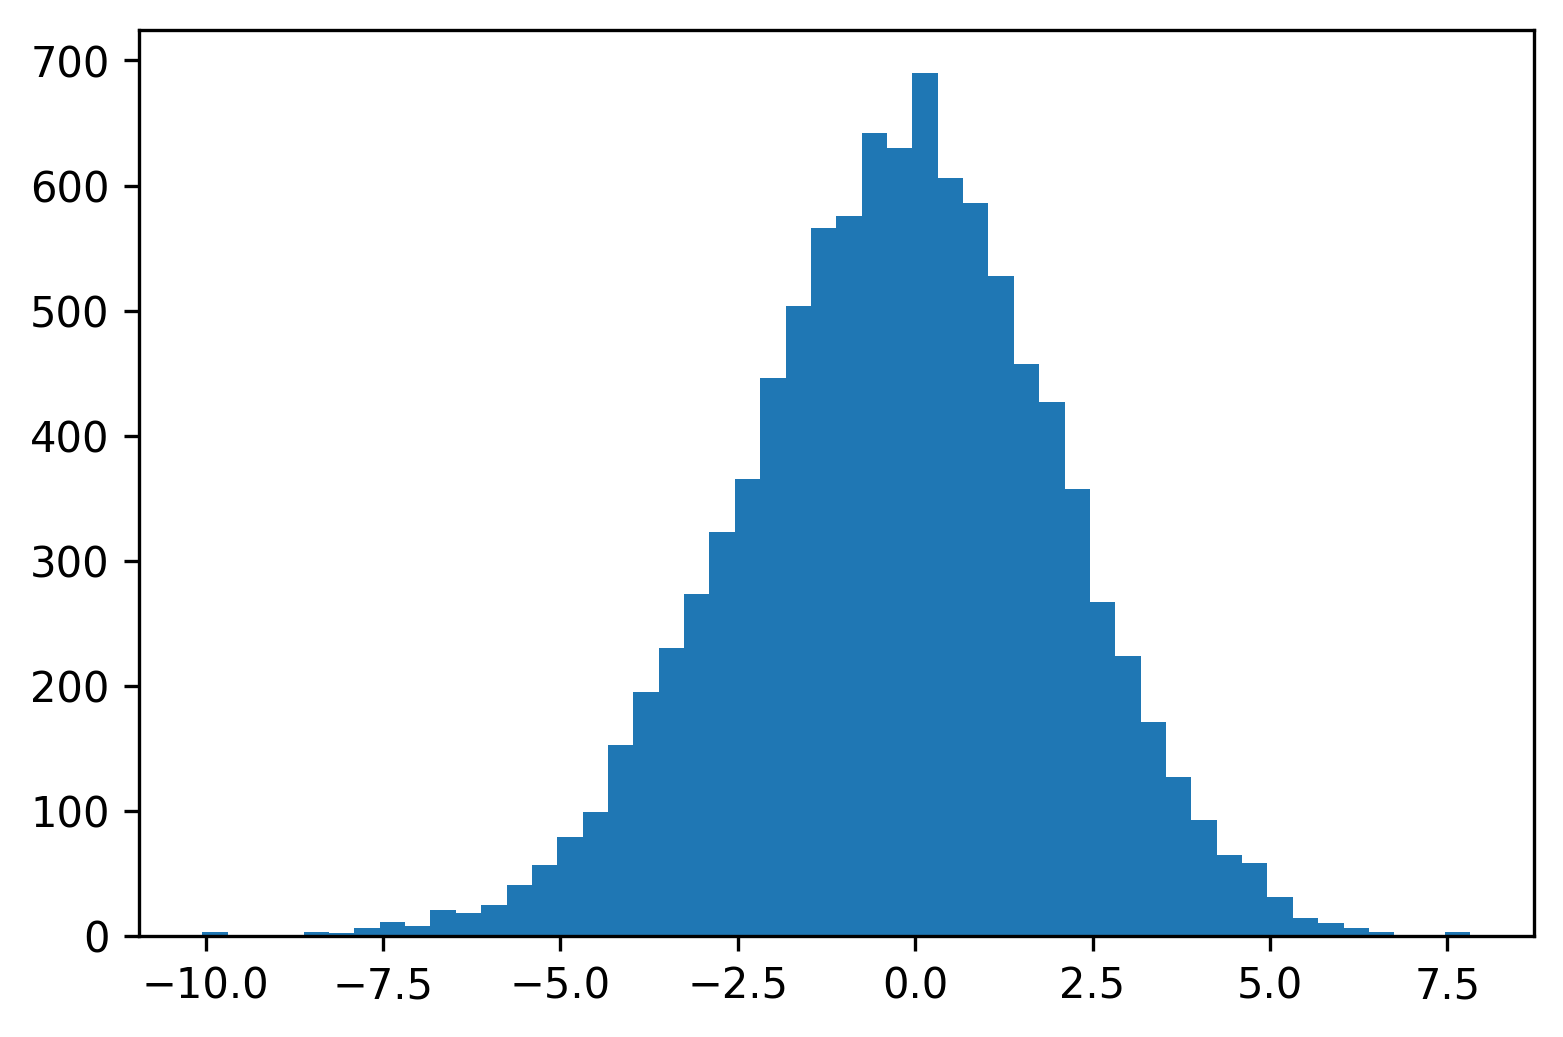

In [18]:
# getting gaussian latent mean and covariance
with torch.no_grad():
    source = list2style(generator.get_latent(torch.randn([10000, 512]).cuda())).cpu().numpy()
    gt_mean = source.mean(0)
    gt_cov = np.cov(source, rowvar=False)

# We show that style space follows gaussian distribution
plt.figure()
plt.hist(source[:, 0], bins=50);

# save the stats for GAN inversion
np.savez('inversion_stats.npz', mean=gt_mean, cov=gt_cov)